In [1]:
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle
import os
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

## Calculating the X-ray Spectrum

In [2]:
kTmin = 0.02
kTmax = 50.0
nkT = 32
zmax = 4.0
nz = 16
emin = 0.5
emax = 2.0

if os.path.isfile("data/Jtot.pck"):
    with open("data/Jtot.pck", "rb") as f:
        J_tot = pickle.load(f)
else:
    rosat_spectrum = rx.ROSATResponse('data/pspcc_gain1_256.rsp')
    J_tot = rosat_spectrum.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax)
    with open("data/Jtot.pck", "wb") as f:
        pickle.dump(J_tot, f)

## Producing the profiles

In [10]:
cosmo = ccl.CosmologyVanillaLCDM()
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)

a = 1.
x = np.geomspace(0.001, 5, 128)
M = 1E14

r200 = mdef.get_radius(cosmo, M, a) / a
r = r200*x

# Battaglia
dens_bg = rx.HaloProfileDensityBattaglia(mass_def=mdef, kind='n_total')
pres_bg = rx.HaloProfilePressureBattaglia(mass_def=mdef, kind='n_total')
tot_bg = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot, dens=dens_bg, pres=pres_bg)
density_bg = dens_bg.real(cosmo, r, M, a)
pressure_bg = pres_bg.real(cosmo, r, M, a)
xtot_bg = tot_bg.real(cosmo, r, M, a)

# Hydrostatic Equilibirum
dens_he = rx.HaloProfileDensityHE(mass_def=mdef, concentration=cM, kind='n_total')
pres_he = rx.HaloProfilePressureHE(mass_def=mdef, concentration=cM, kind='n_total')
tot_he = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot, dens=dens_he, pres=pres_he)
density_he = dens_he.real(cosmo, r, M, a)
pressure_he = pres_he.real(cosmo, r, M, a)
xtot_he = tot_he.real(cosmo, r, M, a)


# NFW
dens_nfw = rx.HaloProfileDensityNFW(mass_def=mdef, concentration=cM, kind='n_total')
pres_nfw = rx.HaloProfilePressureNFW(mass_def=mdef, concentration=cM, kind='n_total')
density_nfw = dens_nfw.real(cosmo, r, M, a)
pressure_nfw = pres_nfw.real(cosmo, r, M, a)
tot_nfw = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot, dens=dens_nfw, pres=pres_nfw)
xtot_nfw = tot_nfw.real(cosmo, r, M, a)

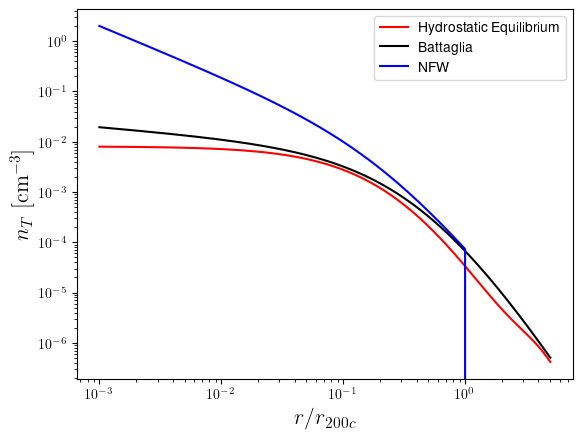

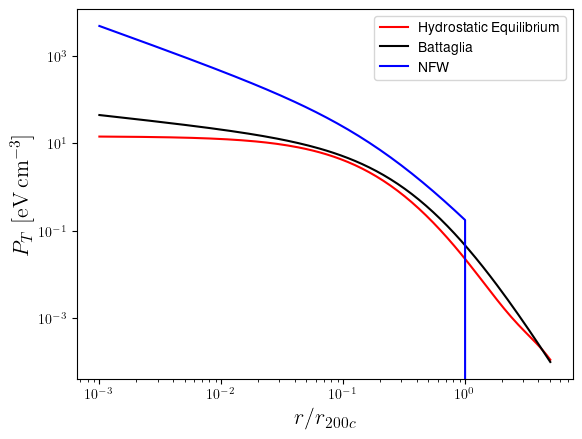

In [11]:
plt.figure()
plt.plot(x, density_he, 'r', label="Hydrostatic Equilibrium")
plt.plot(x, density_bg, 'k', label="Battaglia")
plt.plot(x, density_nfw, 'b', label="NFW")
plt.ylabel(r'$n_T\,\,[{\rm cm}^{-3}]$', fontsize=16)
plt.xlabel(r'$r/r_{200c}$', fontsize=16)
plt.loglog()
plt.legend();

plt.figure()
plt.plot(x, pressure_he, 'r', label="Hydrostatic Equilibrium")
plt.plot(x, pressure_bg, 'k', label="Battaglia")
plt.plot(x, pressure_nfw, 'b', label="NFW")
plt.ylabel(r'$P_T\,\,[{\rm eV}\,{\rm cm}^{-3}]$', fontsize=16)
plt.xlabel(r'$r/r_{200c}$', fontsize=16)
plt.loglog()
plt.legend();

/tmp/ipykernel_7875/465463131.py:10: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(x, 1e-3*pressure_nfw/density_nfw, 'b')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_7875/465463131.py:19: RuntimeWarning: invalid value encountered in divide
  ax[3].plot(x, xtot_nfw/density_nfw**2, 'b-')


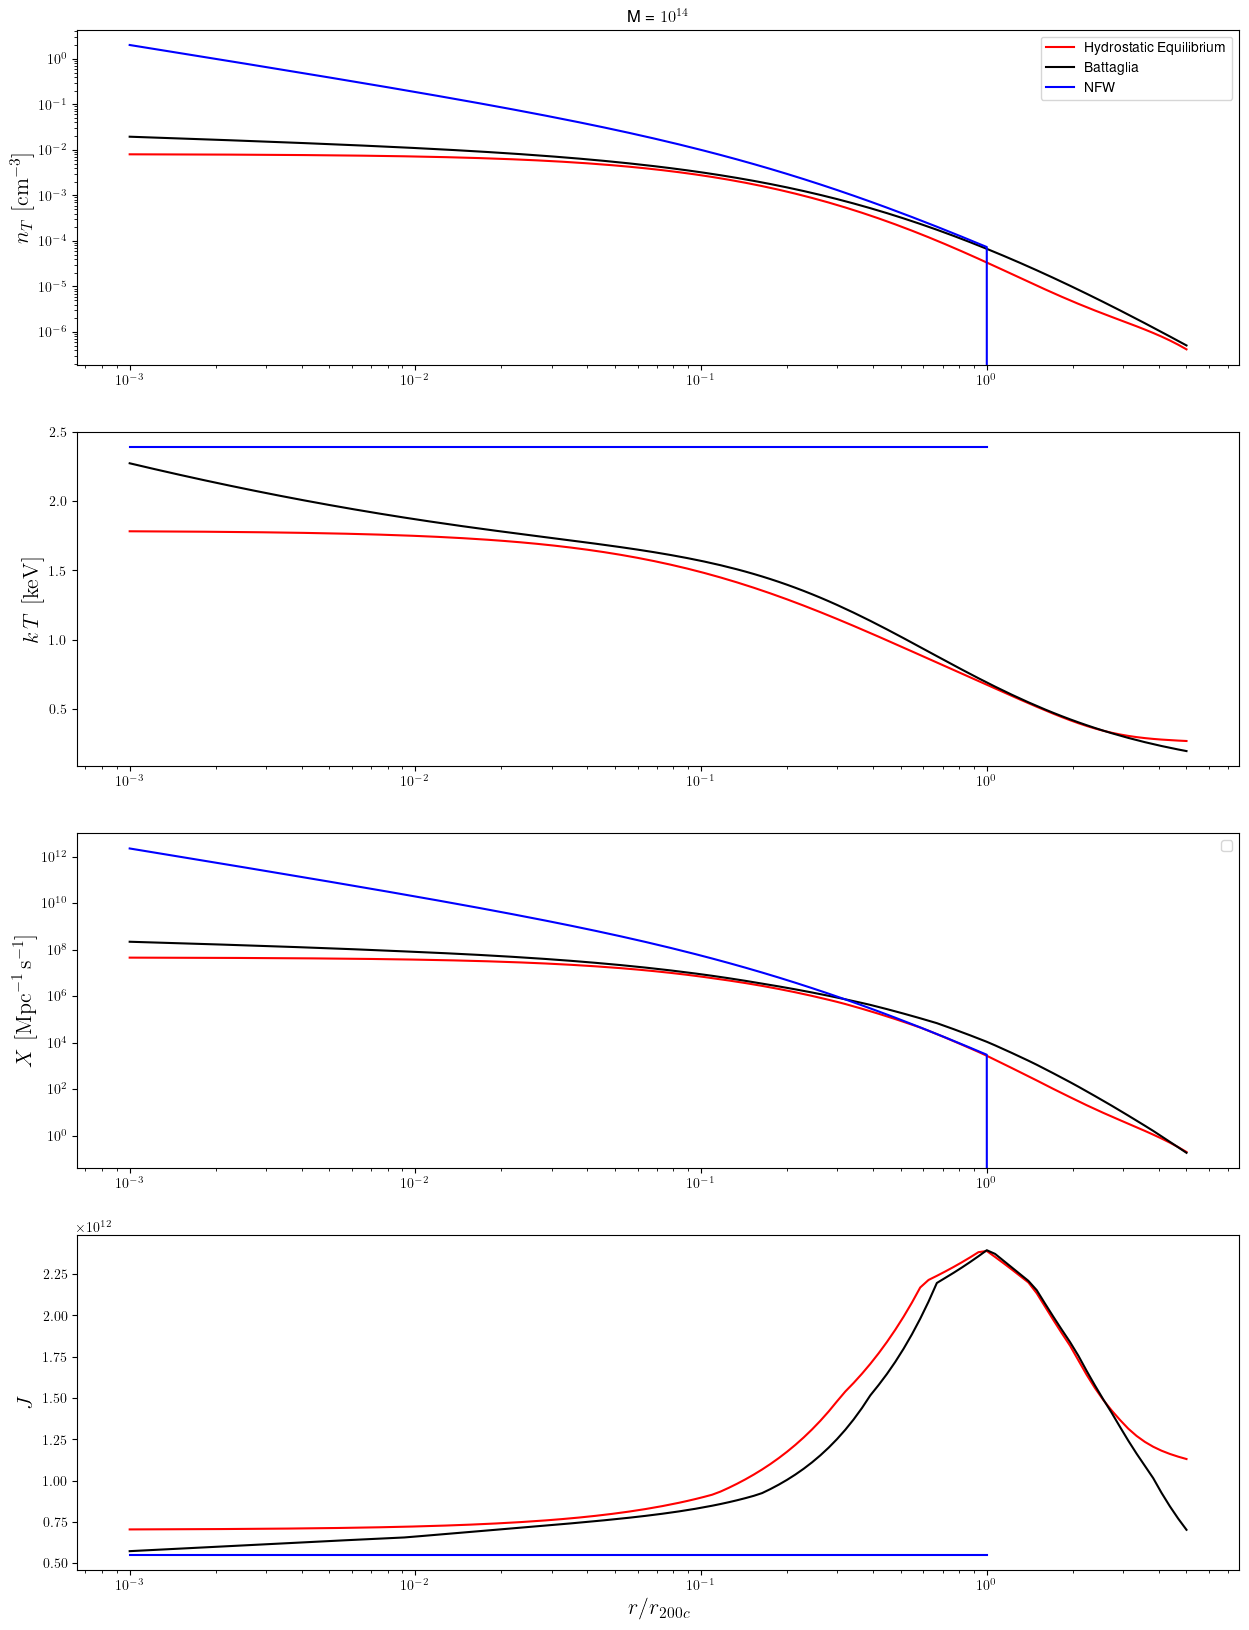

In [12]:
fig, ax = plt.subplots(4, 1, figsize=(15, 20))
    
ax[0].plot(x, density_he, 'r', label='Hydrostatic Equilibrium')
ax[0].plot(x, density_bg, 'k', label='Battaglia')
ax[0].plot(x, density_nfw, 'b', label='NFW')
ax[0].legend()

ax[1].plot(x, 1e-3*pressure_he/density_he, 'r')
ax[1].plot(x, 1e-3*pressure_bg/density_bg, 'k')
ax[1].plot(x, 1e-3*pressure_nfw/density_nfw, 'b')

ax[2].plot(x, xtot_he, 'r-')
ax[2].plot(x, xtot_bg, 'k-')
ax[2].plot(x, xtot_nfw, 'b-')
ax[2].legend()

ax[3].plot(x, xtot_he/density_he**2, 'r-')
ax[3].plot(x, xtot_bg/density_bg**2, 'k-')
ax[3].plot(x, xtot_nfw/density_nfw**2, 'b-')

#ax[0].loglog()
#ax[1].loglog()
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[3].set_xscale('log')
    
ax[0].set_ylabel(r'$n_T\,\,[{\rm cm}^{-3}]$', fontsize=16)
ax[1].set_ylabel(r'$k\,T\,\,[{\rm keV}]$', fontsize=16)
ax[2].set_ylabel(r'$X\,\,[{\rm Mpc}^{-1}\,{\rm s}^{-1}]$', fontsize=16)
ax[3].set_ylabel(r'$J$', fontsize=16)

ax[3].set_xlabel(r'$r/r_{200c}$', fontsize=16)

ax[0].set_title('M = $10^{14}$');

fig.savefig('Plots/Profiles_comparison.pdf')